In [38]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
gtd = pd.read_csv('./gtd-clean.csv')

In [4]:
gtd.head()

,iyear,extended,country,country_txt,region,region_txt,latitude,longitude,specificity,vicinity,...,nkill,nwound,property,propextent,propextent_txt,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,1970,0,58,Dominican Republic,2,Central America & Caribbean,18.456792,-69.951164,1,0,...,1,0,0,3,Minor (likely < $1 million),0,0,0,0,0
1,1970,0,130,Mexico,1,North America,19.432608,-99.133207,1,0,...,0,0,0,3,Minor (likely < $1 million),0,1,1,1,0
2,1970,0,160,Philippines,5,Southeast Asia,15.478598,120.599741,4,0,...,1,0,0,3,Minor (likely < $1 million),-9,-9,1,1,0
3,1970,0,78,Greece,8,Western Europe,37.983773,23.728157,1,0,...,0,0,1,4,Unknown,-9,-9,1,1,0
4,1970,0,101,Japan,4,East Asia,33.580412,130.396361,1,0,...,0,0,1,4,Unknown,-9,-9,1,1,0


In [31]:
#how do we compare the types of attacks, per year, in Great Britain and Ireland (especially during 
#the time of the Troubles w/ the Provisional IRA) in comparison to the rest of Western Europe?
gtd[gtd['country_txt'] == 'United Kingdom'].head()

,iyear,extended,country,country_txt,region,region_txt,latitude,longitude,specificity,vicinity,...,nkill,nwound,property,propextent,propextent_txt,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
364,1970,0,603,United Kingdom,8,Western Europe,54.994510,-7.319996,1,0,...,5,0,1,4,Unknown,0,0,1,1,0
365,1970,0,603,United Kingdom,8,Western Europe,54.994510,-7.319996,1,0,...,3,0,0,3,Minor (likely < $1 million),0,0,1,1,0
366,1970,0,603,United Kingdom,8,Western Europe,54.597269,-5.930109,1,0,...,1,0,0,3,Minor (likely < $1 million),0,0,1,1,0
367,1970,0,603,United Kingdom,8,Western Europe,54.597269,-5.930109,1,0,...,1,0,0,3,Minor (likely < $1 million),0,0,1,1,0
368,1970,0,603,United Kingdom,8,Western Europe,54.597269,-5.930109,1,0,...,3,1,0,3,Minor (likely < $1 million),0,0,1,1,0


In [32]:
gtd[gtd['country_txt'] == 'Ireland'].head()

,iyear,extended,country,country_txt,region,region_txt,latitude,longitude,specificity,vicinity,...,nkill,nwound,property,propextent,propextent_txt,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
171,1970,0,96,Ireland,8,Western Europe,53.344104,-6.267494,1,0,...,1,0,1,4,Unknown,1,1,0,1,0
1057,1971,0,96,Ireland,8,Western Europe,53.344104,-6.267494,1,0,...,1,0,0,3,Minor (likely < $1 million),1,1,0,1,0
1166,1972,0,96,Ireland,8,Western Europe,53.344104,-6.267494,1,0,...,0,0,1,4,Unknown,1,0,1,1,0
1334,1972,0,96,Ireland,8,Western Europe,53.344104,-6.267494,1,0,...,0,0,1,4,Unknown,-9,-9,1,1,0
1486,1972,0,96,Ireland,8,Western Europe,54.123175,-7.478935,1,0,...,2,0,0,3,Minor (likely < $1 million),1,0,1,1,0


In [14]:
gbi = gtd[(gtd['country'] == 603) | (gtd['country'] == 96)]

In [9]:
w_euro = gtd[(gtd['region'] == 8) & ((gtd['country'] != 603) & (gtd['country'] != 96))]

In [15]:
#focusing on the Troubles, so let's pull everything before... let's say 2000, since the conflict ended roughly 1998
gbi = gbi[gbi['iyear'] < 2000]
w_euro = w_euro[w_euro['iyear'] < 2000]

In [16]:
gbi.shape

(4306, 42)

In [17]:
w_euro.shape

(9111, 42)

In [19]:
gbi['attacktype1'].value_counts()

1    1669
3    1558
2     494
7     448
6      61
9      36
8      22
5      12
4       6
Name: attacktype1, dtype: int64

In [20]:
gbi['attacktype1_txt'].value_counts()

Assassination                          1669
Bombing/Explosion                      1558
Armed Assault                           494
Facility/Infrastructure Attack          448
Hostage Taking (Kidnapping)              61
Unknown                                  36
Unarmed Assault                          22
Hostage Taking (Barricade Incident)      12
Hijacking                                 6
Name: attacktype1_txt, dtype: int64

In [21]:
w_euro['attacktype1_txt'].value_counts()

Bombing/Explosion                      5258
Facility/Infrastructure Attack         1277
Assassination                          1180
Armed Assault                           835
Unknown                                 217
Hostage Taking (Kidnapping)             194
Hostage Taking (Barricade Incident)      62
Unarmed Assault                          46
Hijacking                                42
Name: attacktype1_txt, dtype: int64

In [24]:
#let's focus on the percentage of bombings per year, shall we?
gb_bombings = []
euro_bombings = []
for yr in range(1970, 1993):
    gb_yrbmb = len(gbi[(gbi['iyear'] == yr) & (gbi['attacktype1'] == 3)])
    gb_bombings.append(gb_yrbmb / len(gbi[gbi['iyear'] == yr]))
    euro_yrbmb = len(w_euro[(w_euro['iyear'] == yr) & (w_euro['attacktype1'] == 3)])
    euro_bombings.append(euro_yrbmb / len(w_euro[w_euro['iyear'] == yr]))
for yr in range(1994, 2000):
    gb_yrbmb = len(gbi[(gbi['iyear'] == yr) & (gbi['attacktype1'] == 3)])
    gb_bombings.append(gb_yrbmb / len(gbi[gbi['iyear'] == yr]))
    euro_yrbmb = len(w_euro[(w_euro['iyear'] == yr) & (w_euro['attacktype1'] == 3)])
    euro_bombings.append(euro_yrbmb / len(w_euro[w_euro['iyear'] == yr]))
#two for loops because the missing 1993 data causes a divide by zero error

In [25]:
gb_bombings

[0.15384615384615385,
 0.2682926829268293,
 0.22758620689655173,
 0.25,
 0.32682926829268294,
 0.30845771144278605,
 0.23618090452261306,
 0.20279720279720279,
 0.47572815533980584,
 0.4024390243902439,
 0.46099290780141844,
 0.3333333333333333,
 0.3434343434343434,
 0.39226519337016574,
 0.4931506849315068,
 0.5072463768115942,
 0.41237113402061853,
 0.2605633802816901,
 0.4530386740331492,
 0.5240963855421686,
 0.4563758389261745,
 0.2446043165467626,
 0.42704626334519574,
 0.3533834586466165,
 0.24,
 0.4594594594594595,
 0.5121951219512195,
 0.6212121212121212,
 0.4936708860759494]

In [26]:
euro_bombings

[0.3611111111111111,
 0.6744186046511628,
 0.6461538461538462,
 0.40816326530612246,
 0.5225225225225225,
 0.4345991561181435,
 0.4921052631578947,
 0.45222929936305734,
 0.4424920127795527,
 0.51875808538163,
 0.45594713656387664,
 0.5400593471810089,
 0.7293729372937293,
 0.7517006802721088,
 0.7240506329113924,
 0.6952141057934509,
 0.7402234636871509,
 0.7054545454545454,
 0.7564935064935064,
 0.564748201438849,
 0.6639004149377593,
 0.65311004784689,
 0.3831967213114754,
 0.4716981132075472,
 0.3782051282051282,
 0.7494305239179955,
 0.7865168539325843,
 0.6933333333333334,
 0.6560509554140127]

In [27]:
print("GB mean bomb%: " + str(pd.Series(gb_bombings).mean()))
print("EU mean bomb%: " + str(pd.Series(euro_bombings).mean()))

GB mean bomb%: 0.3738136962130469
EU mean bomb%: 0.5879744764048753


In [29]:
#this is a pretty significant difference. But what if we take out the unusually high number of assassinations
#and assassination attempts that occurred in Great Britain during this time period (more than the whole of W. Europe)
gb_wo_asn = []
euro_wo_asn = []
for yr in range(1970, 1993):
    gb_yrbmb = len(gbi[(gbi['iyear'] == yr) & (gbi['attacktype1'] == 3)])
    gb_no_asn = len(gbi[gbi['iyear'] == yr]) - len(gbi[(gbi['iyear'] == yr) & (gbi['attacktype1'] == 1)])
    gb_wo_asn.append(gb_yrbmb / gb_no_asn)
    euro_yrbmb = len(w_euro[(w_euro['iyear'] == yr) & (w_euro['attacktype1'] == 3)])
    euro_no_asn = len(w_euro[w_euro['iyear'] == yr]) - len(w_euro[(w_euro['iyear'] == yr) & (w_euro['attacktype1'] == 1)])
    euro_wo_asn.append(euro_yrbmb / euro_no_asn)
for yr in range(1994, 2000):
    gb_yrbmb = len(gbi[(gbi['iyear'] == yr) & (gbi['attacktype1'] == 3)])
    gb_no_asn = len(gbi[gbi['iyear'] == yr]) - len(gbi[(gbi['iyear'] == yr) & (gbi['attacktype1'] == 1)])
    gb_wo_asn.append(gb_yrbmb / gb_no_asn)
    euro_yrbmb = len(w_euro[(w_euro['iyear'] == yr) & (w_euro['attacktype1'] == 3)])
    euro_no_asn = len(w_euro[w_euro['iyear'] == yr]) - len(w_euro[(w_euro['iyear'] == yr) & (w_euro['attacktype1'] == 1)])
    euro_wo_asn.append(euro_yrbmb / euro_no_asn)

In [30]:
print("GB mean bomb% w/o assassination attempts: " + str(pd.Series(gb_wo_asn).mean()))
print("EU mean bomb% w/o assassination attempts: " + str(pd.Series(euro_wo_asn).mean()))

GB mean bomb% w/o assassination attempts: 0.6090367280242062
EU mean bomb% w/o assassination attempts: 0.6665477219909941


In [40]:
#I think these'll make a much better comparison for our Bayesian inference. Our prior will be Europe, 
#bombings in GB & Ireland will be our new observations
prior_bomb = len(w_euro[w_euro['attacktype1'] == 3])
prior_atk = len(w_euro[w_euro['attacktype1'] != 1])
new_bomb = len(gbi[gbi['attacktype1'] == 3])
new_atk = len(gbi[gbi['attacktype1'] != 1])

In [41]:
alpha_pr = prior_bomb + 1
beta_pr = (prior_atk - prior_bomb) + 1
alpha_po = alpha_pr + new_bomb
beta_po = beta_pr + (new_atk - new_bomb) + 1

In [42]:
prior_dist = stats.beta(alpha_pr, beta_pr)
post_dist = stats.beta(alpha_po, beta_po)

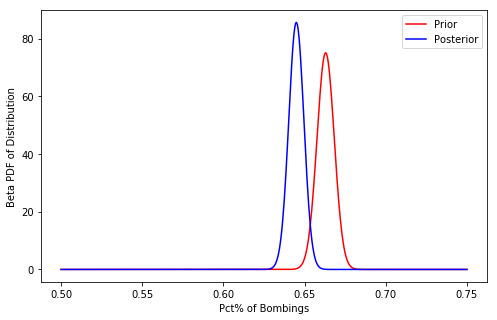

In [52]:
pvals = np.linspace(0.5, 0.75, 501)
plt.figure(figsize=(8, 5))
plt.plot(pvals, prior_dist.pdf(pvals), 'r', label = 'Prior')
plt.plot(pvals, post_dist.pdf(pvals), 'b', label = 'Posterior')
plt.xlabel("Pct% of Bombings")
plt.ylabel("Beta PDF of Distribution")
plt.legend()
plt.show()

In [54]:
with pm.Model() as bomb_model:
    eur = pm.Beta('eur', alpha = alpha_pr, beta = beta_pr, testval = 'mean')
    gbi = pm.Binomial('gbi', n = new_atk, p=eur, observed = new_bomb)
    trace = pm.sample(3000, tune=1000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/arpariseau/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [eur_logodds__]
100%|██████████| 4000/4000 [00:01<00:00, 2526.63it/s]


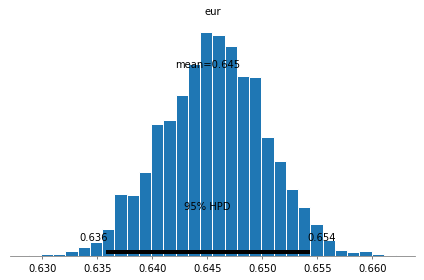

In [55]:
pm.plot_posterior(trace, varnames=['eur'])

In [57]:
gb_bmb_avg = pd.Series(gb_wo_asn).mean()
gb_bmb_std = pd.Series(gb_wo_asn).std()
eu_bmb_avg = pd.Series(euro_wo_asn).mean()
eu_bmb_std = pd.Series(euro_wo_asn).std()
print(eu_bmb_avg)
print(eu_bmb_std)

0.6665477219909941
0.15615211146513908


In [60]:
with pm.Model() as bomb_model2:
    gb_mean = pm.Normal('GB_bomb_pct_AVG', eu_bmb_avg, sd=50)
    gb_std = pm.Uniform('GB_bomb_pct_STD', lower= .01, upper = (2 * eu_bmb_std))
    gb_bmb = pm.Normal('GB_bomb_pct', mu = gb_mean, sd = gb_std, observed = gb_wo_asn)
    trace2 = pm.sample(20000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/arpariseau/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GB_bomb_pct_STD_interval__, GB_bomb_pct_AVG]
100%|██████████| 20500/20500 [00:16<00:00, 1270.21it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x12116de48>,
      dtype=object)

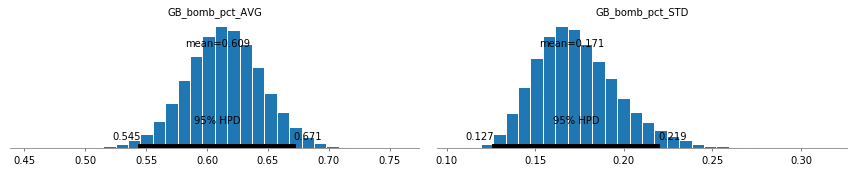

In [61]:
pm.plot_posterior(trace2, varnames=['GB_bomb_pct_AVG', 'GB_bomb_pct_STD'])